##  Vision Transformer on CIFAR-10

In this notebook, we are going to fine-tune a pre-trained [Vision Transformer](https://huggingface.co/docs/transformers/model_doc/vit) (which I added to [🤗 Transformers](https://github.com/huggingface/transformers)) on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset is a collection of 60,000 32x32 colour images in 10 classes, with 6000 images per class.

We will prepare the data using [🤗 datasets](https://github.com/huggingface/datasets), and train the model using the [🤗 Trainer](https://huggingface.co/transformers/main_classes/trainer.html). For other notebooks (such as training ViT with PyTorch Lightning), I refer to my repo [Transformers-Tutorials](https://github.com/NielsRogge/Transformers-Tutorials).

### Quick intro: Vision Transformer (ViT) by Google Brain

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

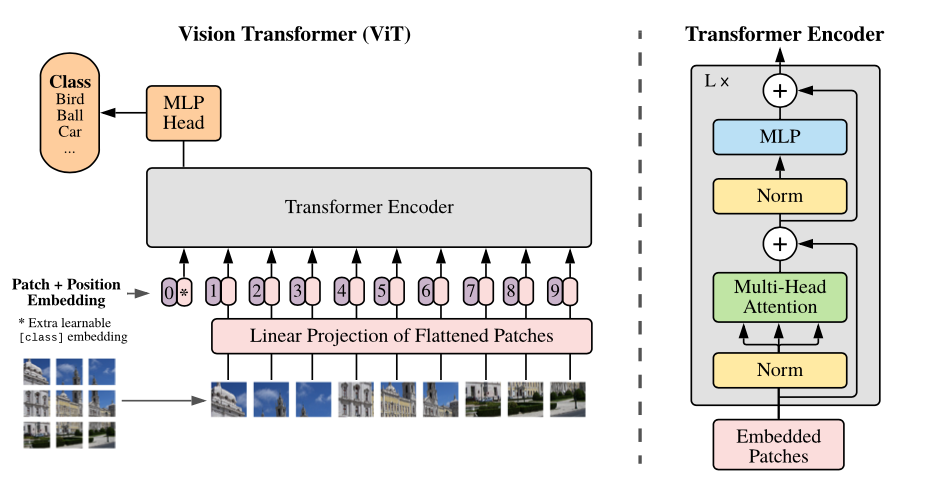

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer


In [ ]:
pip install torchvision

In [2]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision as tv
import numpy as np
import random
import matplotlib.pyplot as plt



In [3]:
# Set Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [4]:
# Set Seeds for Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [5]:
# Set Seeds for Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [6]:
# Define Hyperparameters
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 8
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1


In [7]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [8]:
# Download CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Training samples: 50000
Testing samples: 10000


In [9]:
# Create DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 391
Test batches: 79


In [10]:
# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.patch_size = patch_size

        # Use Conv2D as linear projection
        self.projection = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Calculate number of patches
        self.num_patches = (image_size // patch_size) ** 2

        # CLS token - special learnable token for classification
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Positional embeddings
        self.position_embed = nn.Parameter(
            torch.randn(1, self.num_patches + 1, embed_dim)
        )

    def forward(self, x):
        B = x.shape[0]

        # Project patches: (B, C, H, W) -> (B, embed_dim, H/P, W/P)
        x = self.projection(x)

        # Flatten: (B, embed_dim, H/P, W/P) -> (B, embed_dim, num_patches)
        x = x.flatten(2)

        # Transpose: (B, embed_dim, num_patches) -> (B, num_patches, embed_dim)
        x = x.transpose(1, 2)

        # Expand CLS token for batch
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # Concatenate CLS token
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional embeddings
        x = x + self.position_embed

        return x


In [11]:
# Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, \
            "embed_dim must be divisible by num_heads"

        # Query, Key, Value projections
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Attention scores
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


In [12]:
# MLP (Feed-Forward Network)
class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


In [13]:
# Transformer Encoder Block
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()

        # Layer Norm 1
        self.norm1 = nn.LayerNorm(embed_dim)

        # Multi-Head Attention
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)

        # Layer Norm 2
        self.norm2 = nn.LayerNorm(embed_dim)

        # MLP
        self.mlp = MLP(embed_dim, mlp_dim, dropout)

    def forward(self, x):
        # Residual connection + attention
        x = x + self.attn(self.norm1(x))

        # Residual connection + MLP
        x = x + self.mlp(self.norm2(x))

        return x


In [14]:
# Classification Head
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Extract CLS token (first token)
        x = x[:, 0]
        x = self.norm(x)
        x = self.fc(x)
        return x


In [15]:
# Complete Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size,
        patch_size,
        channels,
        num_classes,
        embed_dim,
        depth,
        num_heads,
        mlp_dim,
        dropout=0.1
    ):
        super().__init__()

        # Patch Embedding
        self.patch_embed = PatchEmbedding(
            image_size, patch_size, channels, embed_dim
        )

        # Transformer Encoder Layers
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])

        # Classification Head
        self.head = ClassificationHead(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.head(x)
        return x


In [16]:
# Instantiate Model
model = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    channels=CHANNELS,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    mlp_dim=MLP_DIM,
    dropout=DROP_RATE
).to(device)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (projection): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
       

In [17]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [18]:
# Training Loop Function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for X, y in loader:
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        out = model(X)

        # Calculate loss
        loss = criterion(out, y)

        # Backward propagation
        loss.backward()

        # Update parameters
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / len(loader.dataset)

    return avg_loss, accuracy


In [19]:
# Evaluation Function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / len(loader.dataset)

    return avg_loss, accuracy


In [20]:
# Train the Model
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("\nStarting training...")
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")



Starting training...
Epoch [1/10] | Train Loss: 1.7552 | Train Acc: 36.28% | Test Loss: 1.5167 | Test Acc: 44.74%
Epoch [2/10] | Train Loss: 1.4157 | Train Acc: 49.23% | Test Loss: 1.3289 | Test Acc: 52.77%
Epoch [3/10] | Train Loss: 1.2702 | Train Acc: 54.42% | Test Loss: 1.2292 | Test Acc: 55.55%
Epoch [4/10] | Train Loss: 1.1618 | Train Acc: 58.40% | Test Loss: 1.1726 | Test Acc: 57.90%
Epoch [5/10] | Train Loss: 1.0871 | Train Acc: 61.25% | Test Loss: 1.1045 | Test Acc: 59.96%
Epoch [6/10] | Train Loss: 1.0152 | Train Acc: 63.86% | Test Loss: 1.1018 | Test Acc: 60.58%
Epoch [7/10] | Train Loss: 0.9502 | Train Acc: 66.09% | Test Loss: 1.0889 | Test Acc: 61.54%
Epoch [8/10] | Train Loss: 0.8875 | Train Acc: 68.64% | Test Loss: 1.0816 | Test Acc: 62.17%
Epoch [9/10] | Train Loss: 0.8329 | Train Acc: 70.47% | Test Loss: 1.0729 | Test Acc: 62.75%
Epoch [10/10] | Train Loss: 0.7750 | Train Acc: 72.57% | Test Loss: 1.0466 | Test Acc: 63.14%


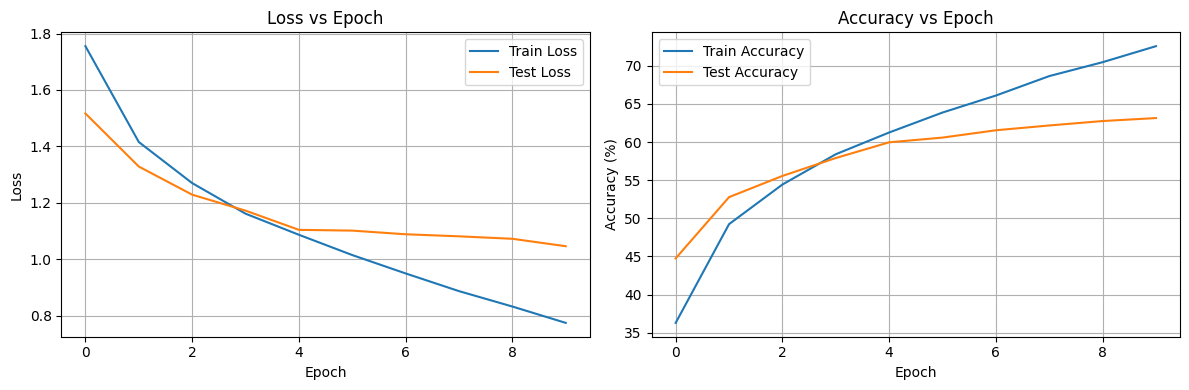

In [21]:
# Visualize Training Results
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()


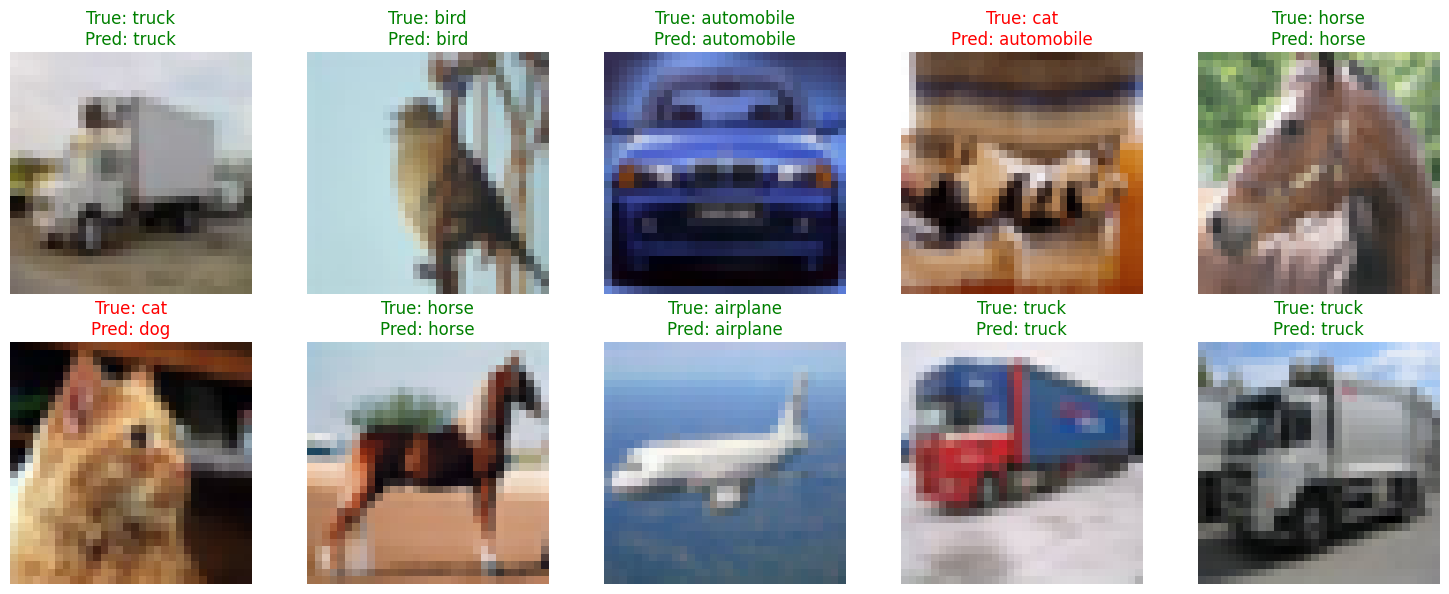

In [22]:
# Make Predictions
def predict_and_visualize(model, dataset, num_images=10):
    model.eval()

    # CIFAR-10 class names
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    # Random indices
    indices = random.sample(range(len(dataset)), num_images)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_input)
            pred = output.argmax(dim=1).item()

        # Denormalize image for visualization
        img = image.permute(1, 2, 0).cpu().numpy()
        img = img * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f'True: {classes[label]}\nPred: {classes[pred]}',
                         color='green' if pred == label else 'red')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()

predict_and_visualize(model, test_dataset, num_images=10)
